Plotting subject: 5f5a5b9360d7fa1045aad5df
Symmetric intensity scale limit M = 0.6694381280808198


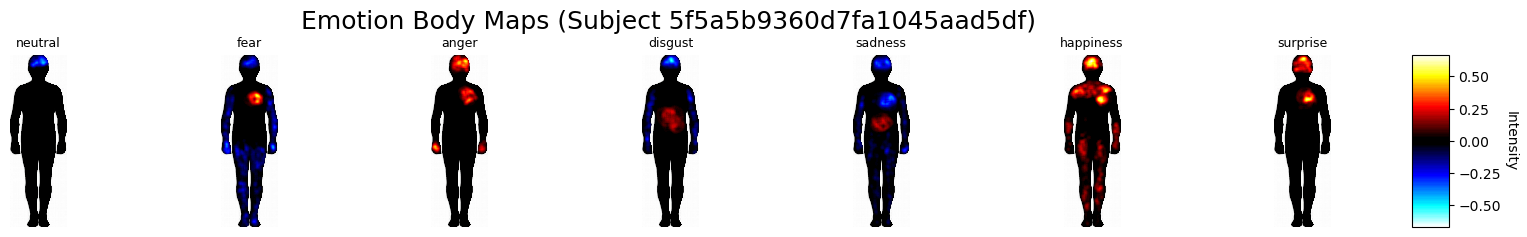

In [8]:
# ---
# Data Preparation: preprocess the data using MATLAB output (.mat files)
# ---

import os
import math
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
from skimage.transform import resize

# -----------------------------------------------------
# Load emotion labels
# -----------------------------------------------------
labels = [
    'Neutral', 'Fear', 'Anger', 'Disgust', 'Sadness', 'Happiness', 'Surprise'
]

raw_maps = {}  # structure: {subject_id: {emotion_label: 2D numpy array}}

# -----------------------------------------------------
# Choose which preprocessed files to load
# -----------------------------------------------------
basepath = r'C:/Users/lovel/Documents/PSYC201/Nummenmaa2013/preprocessed_data_prolific/'

files = sorted([f for f in os.listdir(basepath) if f.endswith('.mat')])

NS = len(files)
NC = 7

# -----------------------------------------------------
# Load MATLAB data into python dictionary
# -----------------------------------------------------
for s, fname in enumerate(files):
    subject_id = fname.split('_')[0]
    mat = scipy.io.loadmat(os.path.join(basepath, fname))
    resmat = mat['resmat']  # shape: [H, W, NC]

    raw_maps[subject_id] = {}

    for n in range(NC):
        subj_map = resmat[:, :, n]
        raw = np.copy(subj_map)

        emotion_label = labels[n].replace(" ", "_").lower()
        raw_maps[subject_id][emotion_label] = raw


# -----------------------------------------------------
# Load base silhouette and mask
# -----------------------------------------------------
base = mpimg.imread('base.png')
mask = mpimg.imread('mask.png')  # α mask: 0–255 or 0–1

# MATLAB→Python corrected crop (inclusive in MATLAB → end-exclusive in Python)
base2 = base[10:532, 33:204, :]

# Normalize mask range
mask_f = mask.astype(float)
if mask_f.max() > 1:
    mask_f = mask_f / 255.0
# If mask is RGB, convert to single channel
if mask_f.ndim == 3:
    mask_f = mask_f[:, :, 0]

# -----------------------------------------------------
# Pick a subject to plot
# -----------------------------------------------------
subject_id = list(raw_maps.keys())[0]
print(f"Plotting subject: {subject_id}")

emotion_keys = list(raw_maps[subject_id].keys())
H_map, W_map = raw_maps[subject_id][emotion_keys[0]].shape
H_base, W_base = base2.shape[:2]

if (H_map, W_map) != (H_base, W_base):
    raise ValueError(
        f"ERROR: Map size {H_map}x{W_map} does not match silhouette size {H_base}x{W_base}.\n"
        "Remove resizing only if they already match."
    )

# -----------------------------------------------------
# Build custom diverging colormap
# -----------------------------------------------------
NumCol = 64
hot = cm.hot(np.linspace(0, 1, NumCol))[:, :3]
cold = np.flipud(hot[:, ::-1])
neutral = np.zeros((2 * round(NumCol * 0.05), 3))
lut = np.vstack([cold, neutral, hot])
final_cmap = ListedColormap(lut)

# compute symmetric intensity bound
all_vals = np.hstack([raw_maps[subject_id][emo].ravel() for emo in emotion_keys])
M = np.max(np.abs(all_vals))
print("Symmetric intensity scale limit M =", M)

# -----------------------------------------------------
# Plot body maps (mask-aware RGBA overlay + safe title spacing)
# -----------------------------------------------------
ncols = 7
nrows = math.ceil(NC / ncols)

fig = plt.figure(figsize=(2.5 * ncols + 2, 2.5 * nrows))
gs = gridspec.GridSpec(
    nrows, ncols + 1,
    width_ratios=[1] * ncols + [0.18],
    wspace=0.05, hspace=0.25
)

for idx, emo in enumerate(emotion_keys):
    row = idx // ncols
    col = idx % ncols
    ax = fig.add_subplot(gs[row, col])

    # Draw silhouette
    ax.imshow(base2, zorder=0)

    # ===== Mask-aware RGBA overlay (no black square) =====
    data = raw_maps[subject_id][emo]  # H×W
    # normalize to [0,1] consistent with vmin=-M, vmax=M
    normed = np.clip((data + M) / (2 * M), 0, 1)
    rgba = final_cmap(normed)          # H×W×4
    rgba[..., 3] = mask_f               # alpha = body mask (0 outside, 1 inside)
    ax.imshow(rgba, interpolation='nearest', zorder=1)

    ax.set_title(emo, fontsize=9)
    ax.axis('off')

# Blank unused subplots
for idx in range(NC, nrows * ncols):
    fig.add_subplot(gs[idx // ncols, idx % ncols]).axis('off')

# Colorbar
cax = fig.add_subplot(gs[:, -1])
sm = plt.cm.ScalarMappable(cmap=final_cmap, norm=plt.Normalize(vmin=-M, vmax=M))
sm.set_array([])
plt.colorbar(sm, cax=cax)
cax.set_ylabel("Intensity", rotation=270, labelpad=12)

# Title & layout — avoid overlap, avoid tight_layout warning
fig.suptitle(f"Emotion Body Maps (Subject {subject_id})", fontsize=18)

# Move the figure content downward so the title sits above it
fig.subplots_adjust(top=0.8)

plt.show()
